In [2]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

In [3]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    
with open('descriptors/new_complete_RANSAC_res5_4by5_descriptors.pickle','rb') as f:
    ransac_descriptors = pickle.load(f)

# Step 2.1: Successive case with generalized spaces

In [ ]:
descriptors = ransac_descriptors

skip = 10

t0 = time.time()

for radius in np.arange(0.5,2.1,0.5):
    
    t1 = time.time()
    t2 = t1
    
    with open('successive_sample_points_per_release.pickle','rb') as f:
        successive_sample_points_per_release = pickle.load(f)
        
    try:
        with open('testing_results/successive/radius_{}_RANSAC_successive_scores.pickle'.format(radius), 'rb') as f:
            g_successive_scores = pickle.load(f)
            
        with open('testing_results/successive/radius_{}_RANSAC_successive_errors.pickle'.format(radius), 'rb') as f:
            g_successive_errors = pickle.load(f)
            
            
        if len(g_successive_scores) != len(g_successive_errors): continue
            
        print("Done with",5*len(g_successive_scores),"releases for radius",radius)
        
    except:

        g_successive_scores = []
        g_successive_errors = []
        
        print("New successive scores for radius",radius)

    for i in np.arange(1,100,skip)[len(g_successive_scores):]: # releases
        
        release_scores = []
        
        g_release_scores = []
        
        count = 0
        
        for k, successive_sample_points_per_release_per_obj in enumerate(successive_sample_points_per_release[i]):
    
            #print("  ",len(successive_sample_points_per_release_per_obj),"releases")
            growing_point_cloud = []
            
            new_vX = []
            new_vZ = []
            
            ransac_pointCloud = []
                
            for [obj_, object_name, original_vertex], reference_ransac in successive_sample_points_per_release_per_obj[:i]:

                try:
                    if len(ransac_pointCloud) == 0: # if empty, open. This only happens at beginning
                        with open("../ransac_pc/ransac_point_collection_{}.pickle".format(reference_ransac),'rb') as f:
                            ransac_trial_point_collection = pickle.load(f)

                        object_, ransac_pointCloud, tri_ = ransac_trial_point_collection[int(obj_)]
                        
                        ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(ransac_pointCloud)), algorithm='kd_tree').fit(ransac_pointCloud[:,:3])

                except:
                    print("Can't get ransac samples for",i,obj_, object_name)
                    continue

                dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
                pointCloud =  ransac_pointCloud[ind_[0,np.where(dist_[0]<=radius)[0]]]

                if len(pointCloud) == 0: continue
                    
                #Regular Accumulation
                if len(growing_point_cloud) == 0:
                    growing_point_cloud = pointCloud

                else:
                    growing_point_cloud = np.concatenate(
                        (growing_point_cloud,pointCloud),
                        axis=0
                    )
                    
                count += 1
                    
            if len(growing_point_cloud) == 0: 
                print("  No pc for release",i,"obj",k,"with name",object_name)
                continue
                    
            #Regular Processing
            growing_point_cloud = np.unique(growing_point_cloud,axis=0)
            
            try:
                p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                    growing_point_cloud,
                    down_resolution = 5,
                    cylindrical_quantization = [4,5]
                )
            except:
                p_descriptors = []
                p_keypoints = []

            # Resetting the diff_Ratio matrix
            diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
            diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
            diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

            local_keypoint_matches = []

            for i_r, ref_descriptor in enumerate(descriptors):

                r_descriptors = ref_descriptor[1]
                r_keypoints = ref_descriptor[2]

                matching_range = np.arange(r_descriptors.shape[1])

                try:    
                    f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                    diff = diff/np.amax(diff) # max-normalization of differences
                    diff_ratio = diff[:,0]/diff[:,1]
                    diff_ratios[:,i_r] = diff_ratio
                    diff_scores[:,i_r] = diff
                    diff_indexs[:,i_r] = f_nearestneighbor

                    # Taking note of the matched keypoints
                    local_keypoint_matches.append([
                        [obj_, object_name, original_vertex],
                        p_keypoints,
                        r_keypoints[f_nearestneighbor[:,0]]
                    ])

                except Exception as ex:
                    print("Error Matching:",ex)

            # Accumulating the diff_ratio matrix for every partial (rotated) object
            g_release_scores.append([
                [obj_, object_name, original_vertex],
                diff_ratios,
                diff_indexs,
                diff_scores,
                local_keypoint_matches
            ])

            if count % 33 == 0:
                #print('Test')
                print("   radius = {}: Done with {} releases ({}) ({} samples). Time to match {:.3f} seconds. ({})".format(
                    radius,
                    i,
                    k,
                    count,
                    time.time()-t2,
                    growing_point_cloud.shape
                )
                     )
                t2 = time.time()

                current_errors = NN_matcher(g_release_scores)
                print("   Error Rate:",np.sum(current_errors[:,1]/len(g_release_scores)))
            
        g_release_errors = NN_matcher(g_release_scores)
        
        try:
            print(radius,i,"Error Rate:",np.sum(g_release_errors[:,1]/len(g_release_errors)))
            #print(radius,i,"G_Error Rate:",np.sum(g_iteration_errors[:,1]/len(g_iteration_scores)))
        except:
            pass
        
        g_successive_scores.append([
            i,
            g_release_scores
        ])
        
        g_successive_errors.append([
            i,
            g_release_errors
        ])
    
        with open('testing_results/successive/radius_{}_RANSAC_successive_scores.pickle'.format(radius), 'wb') as f:
            pickle.dump(g_successive_scores,f)

        with open('testing_results/successive/radius_{}_RANSAC_successive_errors.pickle'.format(radius), 'wb') as f:
            pickle.dump(g_successive_errors,f)
            
        if i % 40  == 1:
            print("  Done with release {}, radius {} ({} actual pcs) in {:.3f} seconds".format(i,radius,count,time.time()-t1))
            t1 = time.time()

        
    print(" Done with generalized submap generation for radius {} in {:.3f} seconds".format(radius,time.time()-t0))
    t0 = time.time()
                

New successive scores for radius 0.5
   radius = 0.5: Done with 1 releases (32) (33 samples). Time to match 66.820 seconds. ((102, 6))
   Error Rate: 0.9090909090909092


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


  No pc for release 1 obj 44 with name Reception-Data61-L5.obj
   radius = 0.5: Done with 1 releases (66) (66 samples). Time to match 71.352 seconds. ((150, 6))
   Error Rate: 0.8484848484848484


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   radius = 0.5: Done with 1 releases (99) (99 samples). Time to match 63.259 seconds. ((113, 6))
   Error Rate: 0.8686868686868685
0.5 1 Error Rate: 0.8686868686868685
  Done with release 1, radius 0.5 (99 actual pcs) in 201.521 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   radius = 0.5: Done with 11 releases (2) (33 samples). Time to match 63.959 seconds. ((5484, 6))
   Error Rate: 0.3333333333333333


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 11 releases (5) (66 samples). Time to match 65.403 seconds. ((2630, 6))
   Error Rate: 0.3333333333333333


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 11 releases (8) (99 samples). Time to match 73.935 seconds. ((5328, 6))
   Error Rate: 0.4444444444444444


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 11 releases (11) (132 samples). Time to match 51.266 seconds. ((1864, 6))
   Error Rate: 0.5833333333333333


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 11 releases (14) (165 samples). Time to match 70.449 seconds. ((5725, 6))
   Error Rate: 0.5333333333333333


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 11 releases (17) (198 samples). Time to match 67.223 seconds. ((3868, 6))
   Error Rate: 0.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 11 releases (20) (231 samples). Time to match 51.555 seconds. ((2162, 6))
   Error Rate: 0.47619047619047616


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 11 releases (23) (264 samples). Time to match 49.953 seconds. ((2546, 6))
   Error Rate: 0.5416666666666666


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 11 releases (26) (297 samples). Time to match 64.153 seconds. ((3934, 6))
   Error Rate: 0.5555555555555556


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 11 releases (29) (330 samples). Time to match 60.265 seconds. ((2841, 6))
   Error Rate: 0.6


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 11 releases (32) (363 samples). Time to match 56.029 seconds. ((3634, 6))
   Error Rate: 0.5757575757575757


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 11 releases (35) (396 samples). Time to match 79.013 seconds. ((3230, 6))
   Error Rate: 0.5833333333333334


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 11 releases (38) (429 samples). Time to match 44.782 seconds. ((1810, 6))
   Error Rate: 0.5384615384615385


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 11 releases (41) (462 samples). Time to match 68.909 seconds. ((3020, 6))
   Error Rate: 0.5476190476190477


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


0.5 11 Error Rate: 0.6500000000000001
   radius = 0.5: Done with 21 releases (10) (231 samples). Time to match 1783.006 seconds. ((4512, 6))
   Error Rate: 0.4545454545454546


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   radius = 0.5: Done with 21 releases (21) (462 samples). Time to match 511.165 seconds. ((5969, 6))


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   Error Rate: 0.4090909090909091
   radius = 0.5: Done with 21 releases (32) (693 samples). Time to match 500.884 seconds. ((5839, 6))


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   Error Rate: 0.4545454545454545
   radius = 0.5: Done with 21 releases (43) (924 samples). Time to match 578.456 seconds. ((4150, 6))


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   Error Rate: 0.43181818181818177


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


0.5 21 Error Rate: 0.4700000000000001
   radius = 0.5: Done with 31 releases (32) (1023 samples). Time to match 4866.165 seconds. ((8308, 6))


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   Error Rate: 0.12121212121212122
   radius = 0.5: Done with 31 releases (48) (1518 samples). Time to match 1109.279 seconds. ((7872, 6))


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   Error Rate: 0.22448979591836737
   radius = 0.5: Done with 31 releases (64) (2013 samples). Time to match 1082.453 seconds. ((9320, 6))


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   Error Rate: 0.2923076923076923
   radius = 0.5: Done with 31 releases (97) (3036 samples). Time to match 2214.241 seconds. ((5708, 6))


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   Error Rate: 0.3469387755102041


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


0.5 31 Error Rate: 0.35000000000000003
   radius = 0.5: Done with 41 releases (32) (1353 samples). Time to match 2888.478 seconds. ((10449, 6))


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   Error Rate: 0.09090909090909091
   radius = 0.5: Done with 41 releases (61) (2541 samples). Time to match 2416.240 seconds. ((7019, 6))


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   Error Rate: 0.16129032258064513


# Step 2.3: Results

In [17]:
succ_NN_errors = []
succ_NN_intra_errors = []

t0 = time.time()

for radius in np.arange(0.5,2.1,0.5):
    
    succ_per_release_errors = []
    succ_per_release_intra_errors = []

    try:
        
        with open('testing_results/successive/radius_{}_RANSAC_successive_scores.pickle'.format(radius), 'rb') as f:
            g_successive_scores = pickle.load(f)
            
        with open('testing_results/successive/radius_{}_RANSAC_successive_errors.pickle'.format(radius), 'rb') as f:
            g_successive_errors = pickle.load(f)
        
        for __, release_errors in g_successive_errors:    
            #print("  RAW",radius,iteration_errors.shape)
            
            succ_per_release_errors.append(np.sum(release_errors[:,1]/len(release_errors)))
            
            intraspace_errors = release_errors[np.where(release_errors[:,1]==0)[0],2]
            
            succ_per_release_intra_errors.append([
                np.nanmean(intraspace_errors),
                np.nanstd(intraspace_errors)  
            ])
       
        succ_NN_errors.append([
            radius,
            np.asarray(succ_per_release_errors)
        ])
        
        succ_NN_intra_errors.append([
            radius,
            np.asarray(succ_per_release_intra_errors)
        ])
        
        #print("Raw",np.asarray(succ_RawNN_per_iteration_errors).shape)

    except Exception as ex:
        print(radius,": successive error results", ex)
        pass
    
with open('testing_results/successive/nn_matcher_errors.pickle', 'wb') as f:
    pickle.dump([succ_NN_errors,succ_NN_intra_errors],f)

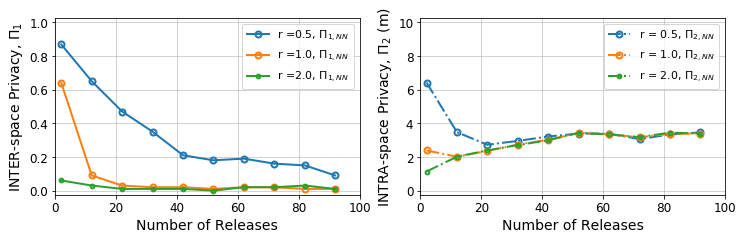

In [16]:
fig=plt.figure(figsize=(12, 3.25))

markersize = 6
linewidth = 2

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,100)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
#ax1.set_xticklabels(np.arange(1,3.1,0.5),fontsize = 12)
#ax1.set_yticklabels([-0.1,0,0.2,0.4,0.6,0.8,1.0],fontsize = 12)
ax1.set_ylabel("INTER-space Privacy, $\Pi_1$", fontsize = 14)
ax1.set_xlabel("Number of Releases", fontsize = 14)

for radius, inter_errors in succ_NN_errors:#[:2]:

    if radius == 1.5: continue

    #print(RawNN_per_iteration_errors.shape)
    ax1.plot(
        np.arange(1,100,skip)[:len(inter_errors):]+1,
        inter_errors[::], 
        '-o', 
        linewidth = linewidth,fillstyle = 'none',
        mew = linewidth,markersize = min(markersize*(1.25/radius),markersize),
        label = "r ="+ str(radius) + ", $\Pi_{1,NN}$"
    )
    

ax1.legend(loc = "best", ncol = 1,fontsize = 11)

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,100)

for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
#ax1.set_xticklabels(np.arange(1,3.1,0.5),fontsize = 12)
#ax1.set_yticklabels([-0.1,0,0.2,0.4,0.6,0.8,1.0],fontsize = 12)
ax2.set_ylabel("INTRA-space Privacy, $\Pi_2$ (m)", fontsize = 14)
ax2.set_xlabel("Number of Releases", fontsize = 14)

for radius, intra_errors in succ_NN_intra_errors:#[:2]:
    
    if radius == 1.5: continue
    
    ax2.plot(
        np.arange(1,100,skip)+1,#[:len(intra_errors):2]+1,
        intra_errors[::,0], 
        '-.o',
        linewidth = linewidth, #capsize = 4.0, 
        #marker = markers[0],
        fillstyle = 'none',
        mew = linewidth,markersize = min(markersize*(1.25/radius),markersize),
        label = "r = "+ str(radius) + ", $\Pi_{2,NN}$"
    )
    
#    print(intra_errors[:,0])

ax2.legend(loc = "best", ncol = 1,fontsize = 11)
